In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
#Load your dataset
df = pd.read_csv("transformed_data.csv")

#Ensure the 'Datum' column is in datetime format
df['Datum'] = pd.to_datetime(df['Datum'])

#Define time ranges
train_start = '2013-07-01'
train_end = '2017-07-31'
val_start = '2017-08-01'
val_end = '2018-07-31'
test_start = '2018-08-01'
test_end = '2019-07-30'

#Split data
train_data = df[(df['Datum'] >= train_start) & (df['Datum'] <= train_end)]
validation_data = df[(df['Datum'] >= val_start) & (df['Datum'] <= val_end)]
test_data = df[(df['Datum'] >= test_start) & (df['Datum'] <= test_end)]

#Optional: print shapes
print("Train shape:", train_data.shape)
print("Validation shape:", validation_data.shape)
print("Test shape:", test_data.shape)

Train shape: (7517, 13)
Validation shape: (1839, 13)
Test shape: (351, 13)


In [4]:
df.head()

,Datum,Weekday,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,id,Warengruppe,Umsatz,KielerWoche,Weather_Category,Weather_Category_Wind_Adjusted,Wind_Downgrade_Count
0,2012-01-01,Sunday,8.0,9.82,14,58.0,NaN,NaN,NaN,NaN,Rain,Rain,0
1,2012-01-02,Monday,7.0,7.44,12,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,0
2,2012-01-03,Tuesday,8.0,5.54,18,63.0,NaN,NaN,NaN,NaN,Rain,Rain,0
3,2012-01-04,Wednesday,4.0,5.69,19,80.0,NaN,NaN,NaN,NaN,Rain,Rain,0
4,2012-01-05,Thursday,6.0,5.30,23,80.0,NaN,NaN,NaN,NaN,Rain,Rain,0


In [5]:
columns = train_data.columns.tolist()
columns

['Datum',
 'Weekday',
 'Bewoelkung',
 'Temperatur',
 'Windgeschwindigkeit',
 'Wettercode',
 'id',
 'Warengruppe',
 'Umsatz',
 'KielerWoche',
 'Weather_Category',
 'Weather_Category_Wind_Adjusted',
 'Wind_Downgrade_Count']

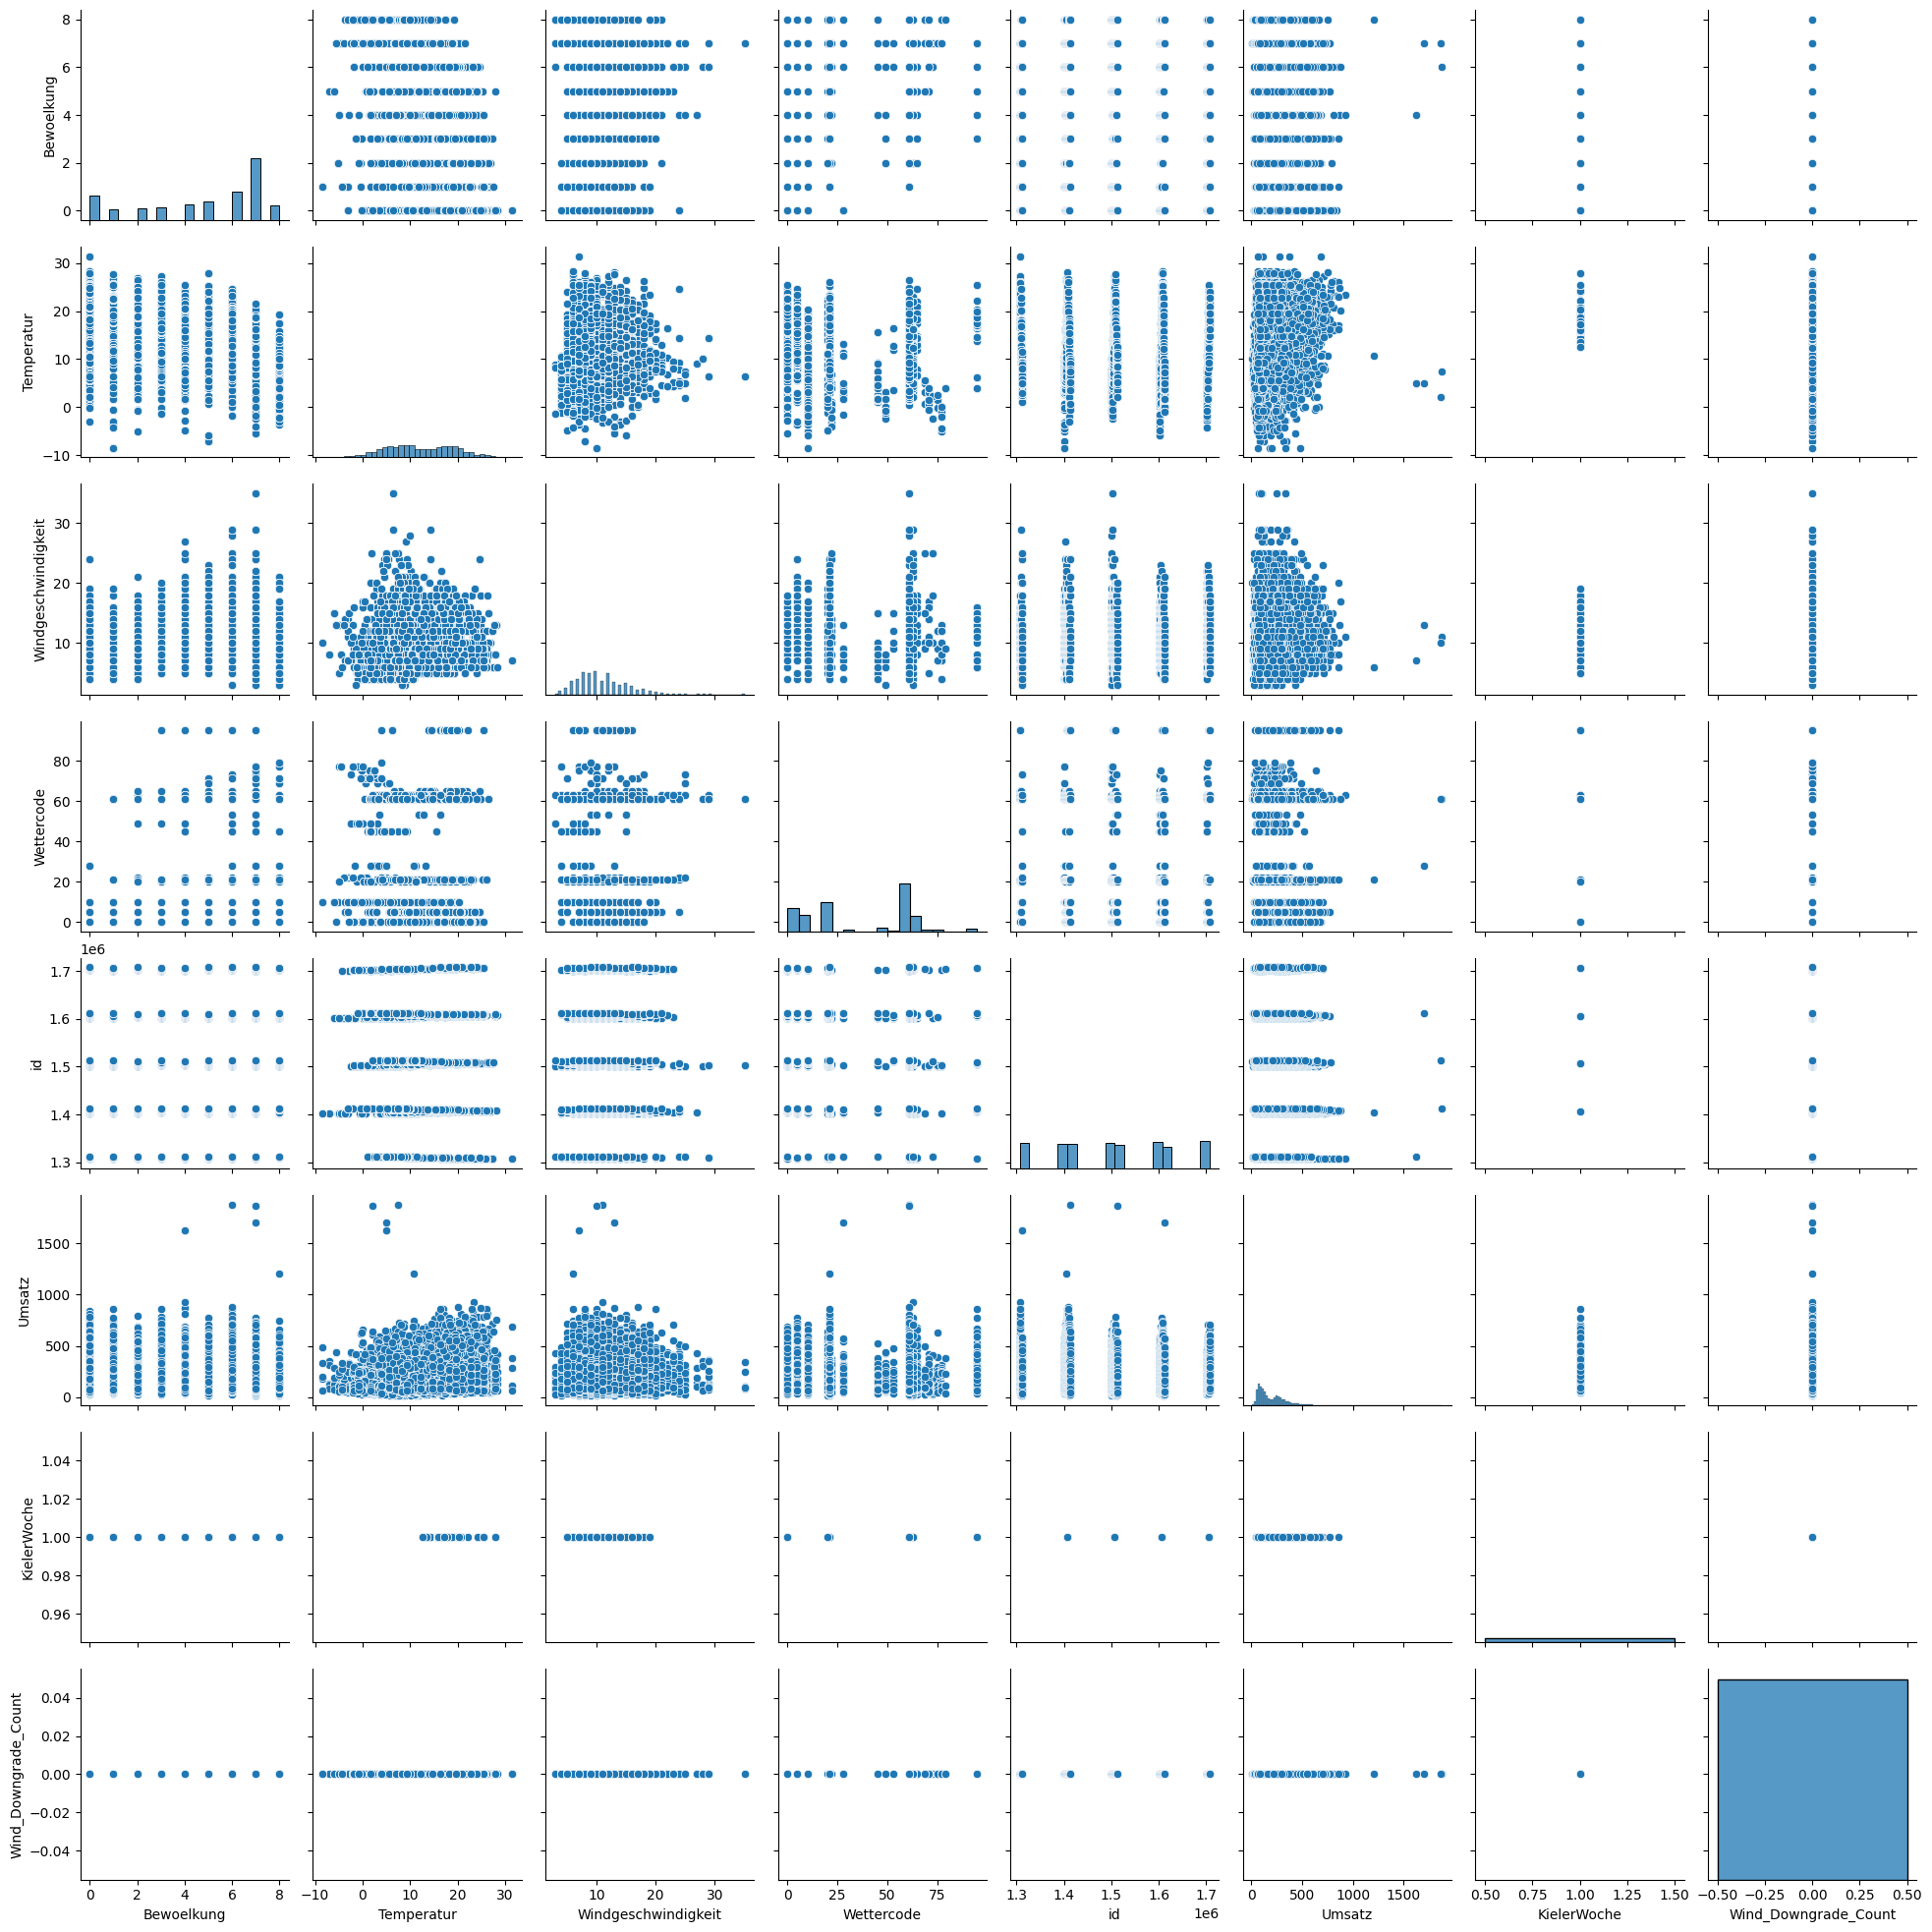

In [15]:
sns.pairplot(train_data[columns])

In [16]:
#remove all non-numeric columns for correlation
columns = [col for col in columns if train_data[col].dtype in ['float64', 'int64']]
train_data[columns].corr()

,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,id,Umsatz,KielerWoche,Wind_Downgrade_Count
Bewoelkung,1.000000,-0.376459,0.042912,0.478444,0.041113,-0.085921,NaN,NaN
Temperatur,-0.376459,1.000000,0.003471,0.011623,-0.095729,0.216570,NaN,NaN
Windgeschwindigkeit,0.042912,0.003471,1.000000,0.127076,0.027233,0.011454,NaN,NaN
Wettercode,0.478444,0.011623,0.127076,1.000000,-0.053262,0.001147,NaN,NaN
id,0.041113,-0.095729,0.027233,-0.053262,1.000000,-0.097429,NaN,NaN
Umsatz,-0.085921,0.216570,0.011454,0.001147,-0.097429,1.000000,NaN,NaN
KielerWoche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wind_Downgrade_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#fing highest correlation
correlation_matrix = train_data[columns].corr()
highest_correlation = correlation_matrix.abs().unstack().sort_values(ascending=False)
# Remove self-correlations
highest_correlation = highest_correlation[highest_correlation < 1.0]
# Get the top 10 highest correlations
top_10_correlations = highest_correlation.head(10)
print("Top 10 highest correlations:")
print(top_10_correlations)

Top 10 highest correlations:
Bewoelkung           Wettercode             0.478444
Wettercode           Bewoelkung             0.478444
Temperatur           Bewoelkung             0.376459
Bewoelkung           Temperatur             0.376459
Umsatz               Temperatur             0.216570
Temperatur           Umsatz                 0.216570
Wettercode           Windgeschwindigkeit    0.127076
Windgeschwindigkeit  Wettercode             0.127076
Umsatz               id                     0.097429
id                   Umsatz                 0.097429
dtype: float64


<Axes: xlabel='Temperatur', ylabel='Umsatz'>

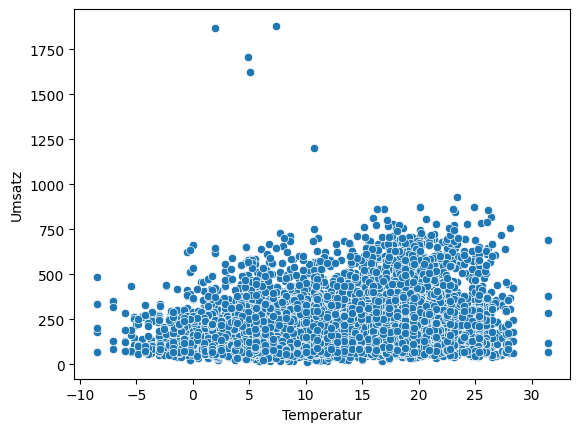

In [18]:
#scatterplot of Bewoelkung and Wettercode
sns.scatterplot(data=train_data, x='Temperatur', y='Umsatz')

In [19]:
Y = train_data['Umsatz']
X = sm.add_constant(train_data['Temperatur'])

# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X['Temperatur'].notna()
Y_clean = Y[valid_idx]
X_clean = X[valid_idx]

model = sm.OLS(Y_clean, X_clean)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     368.3
Date:                Mon, 26 May 2025   Prob (F-statistic):           3.54e-80
Time:                        13:37:27   Log-Likelihood:                -47846.
No. Observations:                7487   AIC:                         9.570e+04
Df Residuals:                    7485   BIC:                         9.571e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        154.3321      3.316     46.539      0.0

In [25]:
print(train_data['Warengruppe'])

394           Brot
395       Brötchen
396      Croissant
397     Konditorei
398         Kuchen
           ...    
7906          Brot
7907      Brötchen
7908     Croissant
7909    Konditorei
7910        Kuchen
Name: Warengruppe, Length: 7517, dtype: object


In [36]:
Y = train_data['Umsatz']
X = sm.add_constant(pd.get_dummies(train_data['Warengruppe'], drop_first=True, dtype=int))
X.head()
# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X.notna().all(axis=1)
Y_clean = Y[valid_idx]
X_clean = X[valid_idx]

model = sm.OLS(Y_clean, X_clean)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     2783.
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        14:16:52   Log-Likelihood:                -44092.
No. Observations:                7487   AIC:                         8.820e+04
Df Residuals:                    7481   BIC:                         8.824e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        121.3782      2.287     53.079      0.0

In [21]:
# multiple linear regression model
X = train_data[['Temperatur', 'Wettercode', 'Bewoelkung']]
Y = train_data['Umsatz']
X = sm.add_constant(X)
# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X[['Temperatur', 'Wettercode', 'Bewoelkung']].notna().all(axis=1)
Y_clean = Y[valid_idx]
X_clean = X[valid_idx]
model = sm.OLS(Y_clean, X_clean)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     92.72
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.66e-58
Time:                        13:38:17   Log-Likelihood:                -34345.
No. Observations:                5399   AIC:                         6.870e+04
Df Residuals:                    5395   BIC:                         6.873e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        153.2443      6.632     23.107      0.0

In [13]:
# predict new values
m1 = results.params['Temperatur']
m2 = results.params['Wettercode']
m3 = results.params['Bewoelkung']
b = results.params['const']
# Example prediction
Temp = 20  # Example temperature
Wettercode = 1  # Example weather code
Bewoelkung = 5  # Example cloudiness level
Umsatz = m1 * Temp + m2 * Wettercode + m3 * Bewoelkung + b
print(Umsatz)

241.1002474367276
